In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

import seaborn as sns


file_path = "A1_dataset.csv"

data = pd.read_csv(file_path)

print(data.head())


   Target  Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  \
0      -1    -0.294118  0.487437       0.180328      -0.292929 -1.000000   
1       1    -0.882353 -0.145729       0.081967      -0.414141 -1.000000   
2      -1    -0.058824  0.839196       0.049180      -1.000000 -1.000000   
3       1    -0.882353 -0.105528       0.081967      -0.535354 -0.777778   
4      -1    -1.000000  0.376884      -0.344262      -0.292929 -0.602837   

        BMI  DiabetesPedigreeFunction       Age  
0  0.001490                 -0.531170 -0.033333  
1 -0.207153                 -0.766866 -0.666667  
2 -0.305514                 -0.492741 -0.633333  
3 -0.162444                 -0.923997 -1.000000  
4  0.284650                  0.887276 -0.600000  


In [2]:
# Data preprocessing
print("Statistical Summary:")
print(data.describe())


print("\nMissing Values Check:")
print(data.isnull().sum())

print("\nTarget Variable Distribution:")
print(data['Target'].value_counts())

data['Age'].fillna(data['Age'].median(), inplace=True)

print("\nMissing Values Check After Handling:")
print(data.isnull().sum())


Statistical Summary:
           Target  Pregnancies     Glucose  BloodPressure  SkinThickness  \
count  768.000000   768.000000  768.000000     768.000000     768.000000   
mean     0.302083    -0.547641    0.215020       0.131574      -0.585122   
std      0.953903     0.396421    0.321333       0.319896       0.322267   
min     -1.000000    -1.000000   -1.000000      -1.000000      -1.000000   
25%     -1.000000    -0.882353   -0.005025       0.016393      -1.000000   
50%      1.000000    -0.647059    0.175879       0.180328      -0.535354   
75%      1.000000    -0.294118    0.409547       0.311475      -0.353535   
max      1.000000     1.000000    1.000000       1.000000       1.000000   

          Insulin         BMI  DiabetesPedigreeFunction         Age  
count  768.000000  768.000000                768.000000  759.000000  
mean    -0.810410   -0.047279                 -0.662247   -0.599166  
std      0.273036    0.237041                  0.284229    0.388652  
min     -1.000

In [3]:
# Initial split into train and test (80% train, 20% test)
X = data.drop('Target', axis=1)  
y = data['Target']  

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training set into train (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Check the split sizes
print(f"Training Set Size: {X_train.shape}")
print(f"Validation Set Size: {X_val.shape}")
print(f"Test Set Size: {X_test.shape}")



Training Set Size: (491, 8)
Validation Set Size: (123, 8)
Test Set Size: (154, 8)


In [4]:
# Initialize the Perceptron model with a fixed random state for reproducibility
perceptron = Perceptron(random_state=42)

# Train the model using the training set
perceptron.fit(X_train, y_train)



Perceptron(random_state=42)

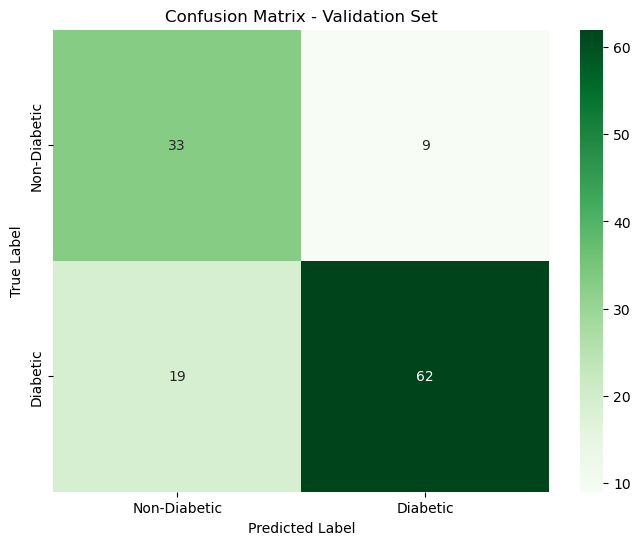

Validation Accuracy: 0.7724

Validation Set Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.79      0.70        42
           1       0.87      0.77      0.82        81

    accuracy                           0.77       123
   macro avg       0.75      0.78      0.76       123
weighted avg       0.79      0.77      0.78       123



In [8]:
y_val_pred = perceptron.predict(X_val)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Compute the validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
                              
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens',fmt='d',
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()


# Print the classification report for detailed metrics
print(f"Validation Accuracy: {val_accuracy:.4f}\n")
print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'alpha': 0.0001, 'eta0': 1.0, 'max_iter': 500, 'penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.7168


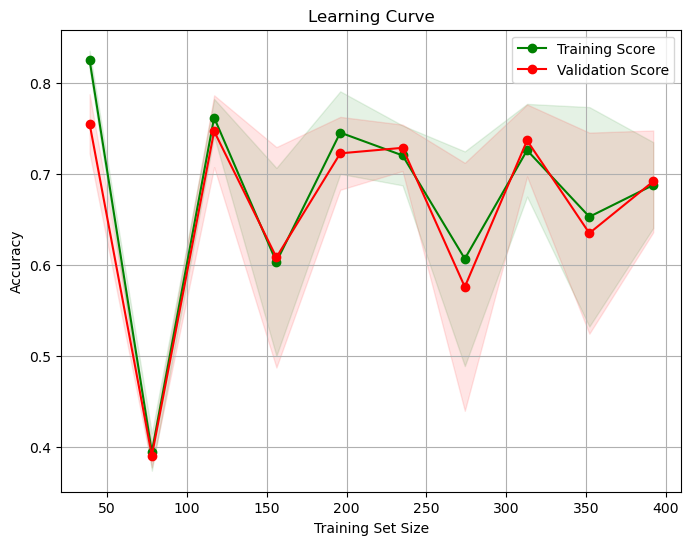

In [11]:
# Define a hyperparameter grid for optimization
param_grid = {
    'penalty': ['l2', 'elasticnet'],  
    'alpha': [0.0001, 0.001, 0.01],   
    'eta0': [0.01, 0.1, 1.0],        
    'max_iter': [500, 1000, 2000]      
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=Perceptron(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Perform the hyperparameter search
grid_search.fit(X_train, y_train)

# Display the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Use the best estimator to plot the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='green')

plt.plot(train_sizes, val_mean, label='Validation Score', marker='o', color='red')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


Test Accuracy: 0.7273

Test Set Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.27      0.42        55
           1       0.71      0.98      0.82        99

    accuracy                           0.73       154
   macro avg       0.80      0.63      0.62       154
weighted avg       0.77      0.73      0.68       154



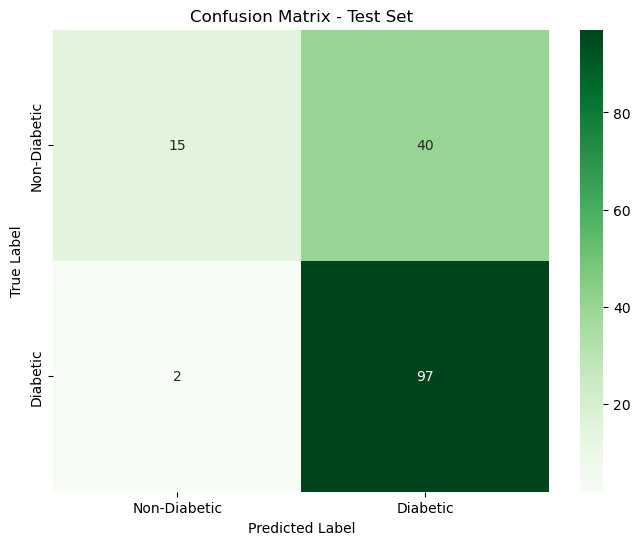

In [9]:
# Use the best training model to the final training and testing
best_model = grid_search.best_estimator_

# Train the best model on the training set, including validation data
best_model.fit(X_train_full, y_train_full)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Calculate the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Display the Classification Report
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d',
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()
